# Dimensional Reduction: I

*N. Pol (2025)*

This lecture and notebook are based on the "DimensionReduction" and "DimensionReduction2" lectures of of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), which in turn are based on materials from Connolly, Leighly, VanderPlas, Geron, and Ivezic Ch. 7.0-7.4.

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 7.

---

## Contents
* [Curse Of Dimensionality](#one)
* [Principal Component Analysis](#two)
* [Non-negative Matrix Factorization](#three)
* [Independent Component Analysis](#four)
    
---

***Exercises required for class participation are in <font color='red'>red</font>.***

---

## Curse of Dimensionality <a class="anchor" id="one"></a>

You really want to buy a car. Like, right now--you don't want to wait. But... you are picky, and have certain things that you would like it to have. 

Each of those things has a probability between 0 and 1 of being on the the car dealer's lot. You want a red car, which has a probability of being on the lot of $p_{\rm red}$; you want good gas mileage, $p_{\rm gas}$; you want leather seats, $p_{\rm leather}$; and you want a sunroof, $p_{\rm sunroof}$. The probability that the dealer has a car on the lot that meets all of those requirements is 

$$p_{\rm red} \times p_{\rm gas} \times p_{\rm leather} \times p_{\rm sunroof},$$

or $p^n$ where $n$ is the number of features (assuming equal probability for each).

If the probability of each of these is $50\%$, then the probability of you driving off with your car of choice is **only $0.5\times0.5\times0.5\times0.5 = 0.0625$**. Not very good. Imagine if you also wanted other things. **This is the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).**

Let's illustrate the curse of dimensionality with two figures from [here.](https://medium.freecodecamp.org/the-curse-of-dimensionality-how-we-can-save-big-data-from-itself-d9fa0f872335)

* **In the first example we are trying to find a box holding some treasure, which gets harder and harder with more dimensions, despite there just being 5 boxes in each dimension:**
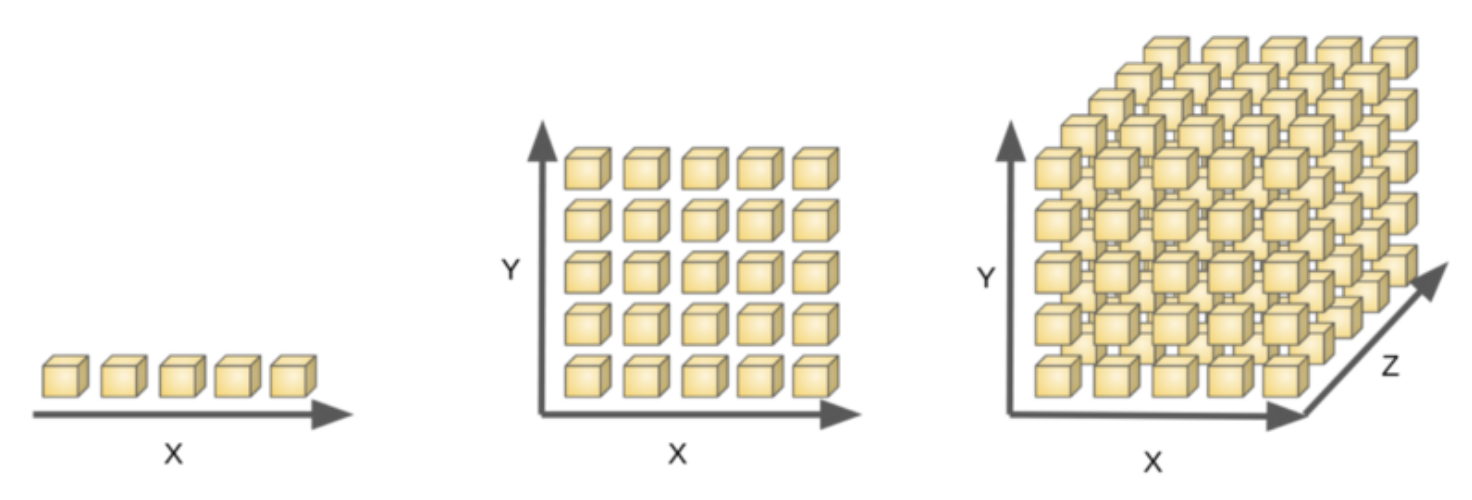

* **In the next example we inscribe a circle in a square. The area outside of the circle grows larger and larger as the number of dimensions increase:**
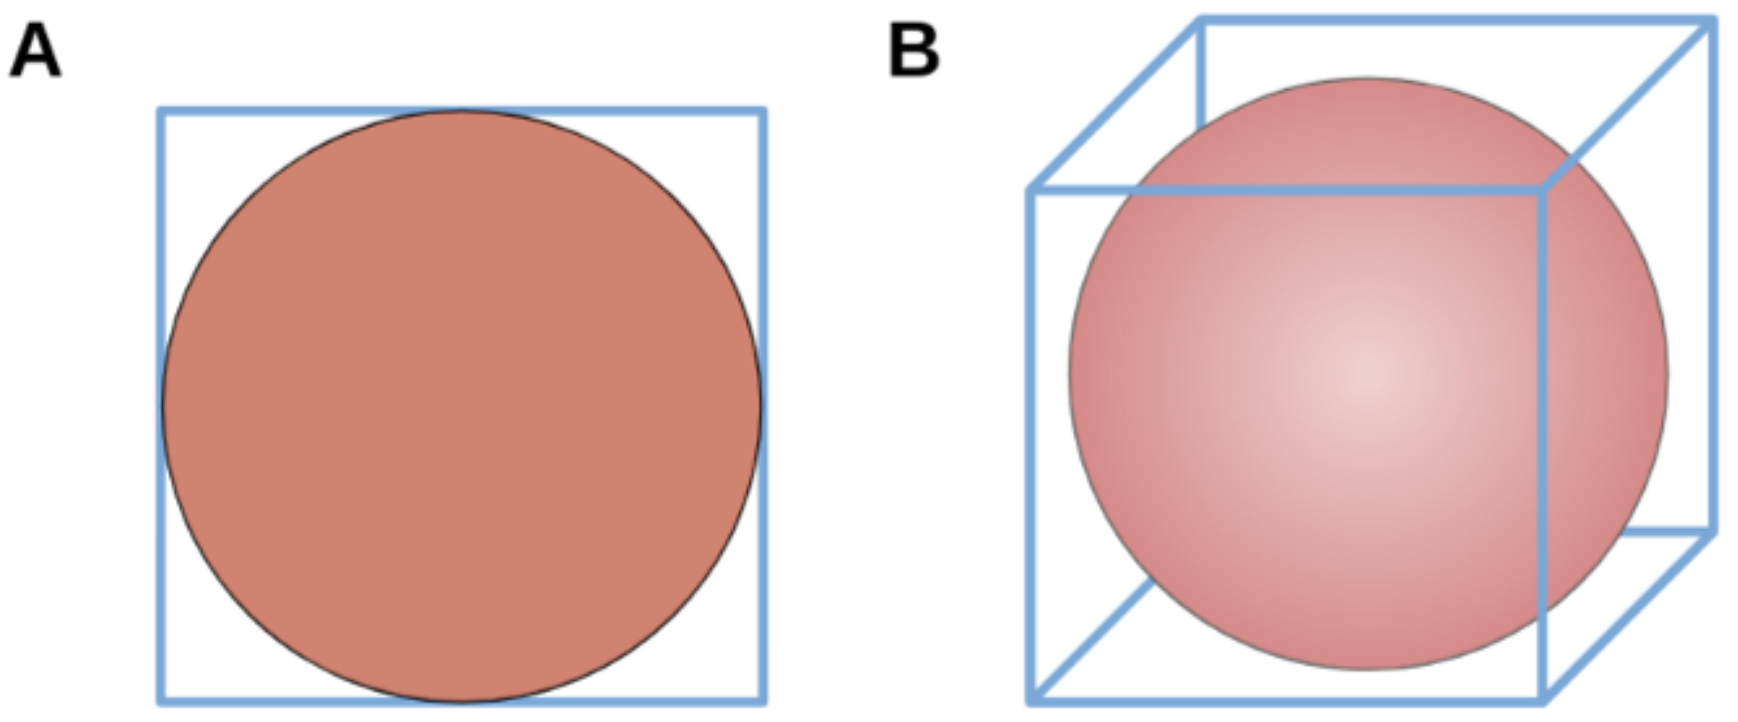

* Mathematically we can describe this as: 
> the more dimensions that your data span, the more points are needed to uniformly sample the space.  
* Another consequence of this is the general statement that most of the volume of a $D$-dimensional hypercube is in the corners!

Let's work this out mathematically and numerically. For $D$ dimensions with coordinates $[-1,1]$ (i.e. in a hypercube), the fraction of points in a hypersphere (with radius $r$, as illustrated above) is

$$f_D = \frac{V_D(r)}{(2r)^D} = \frac{\pi^{D/2}}{D2^{D-1}\Gamma(D/2)}$$

which tends to $0$ as $D$ tends to infinity! 

***Actually, as you can see from the numerical calculation and plot below, it is effectively $0$ much earlier than that!***

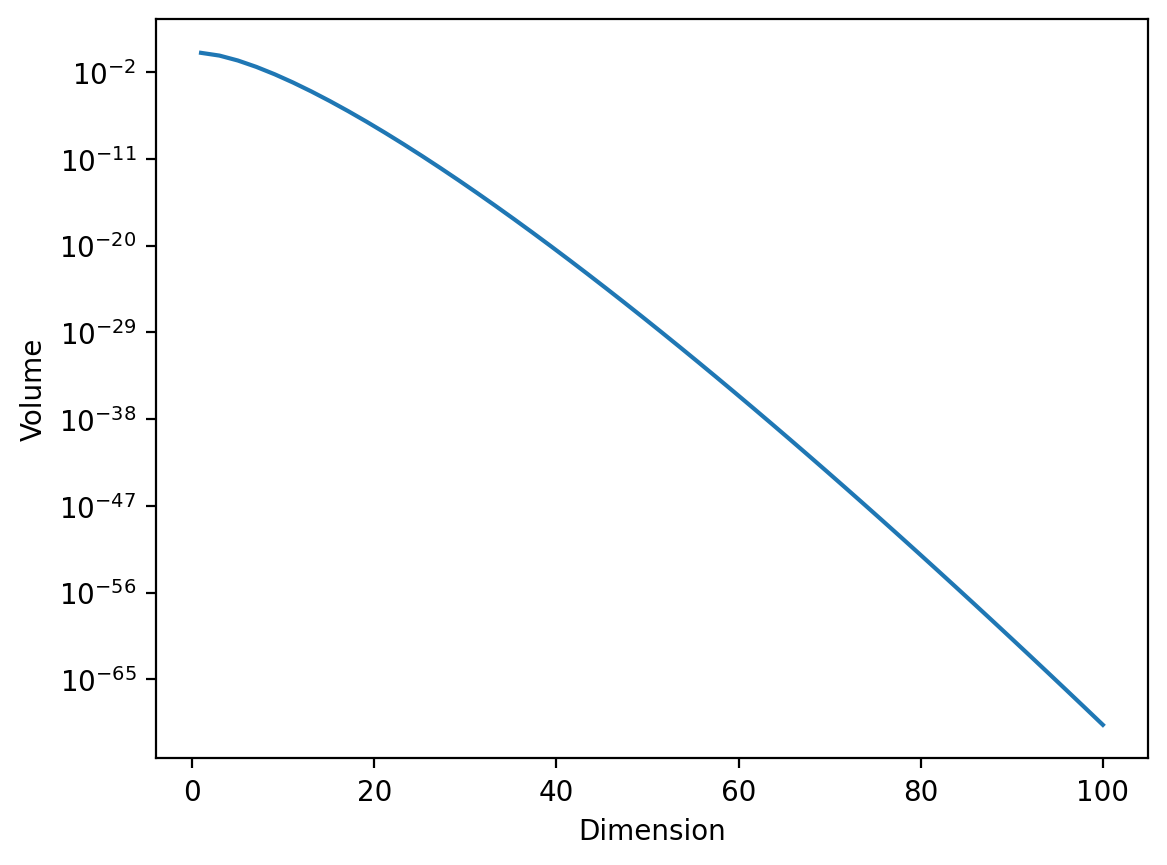

In [1]:
# Execute this cell
# from Andy Connolly
import numpy as np
from scipy import stats
import scipy.special as sp
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


def unitVolume(dimension, radius=1.):
    return 2 * ((radius**dimension * np.pi**(dimension/2.)) 
                / (dimension * sp.gamma(dimension/2.)))

dim = np.linspace(1,100)

#------------------------------------------------------------
# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dim,unitVolume(dim)/2.**dim)

ax.set_yscale('log')
ax.set_xlabel('Dimension')
ax.set_ylabel('Volume')

plt.show()

* Note that this works in the opposite direction too: let's say you want to find "rare" objects in 10 dimensions, where we'll define rare as $<1\%$ of the population.
* Then you'll need to accept objects from $63\%$ of the distribution in all 10 dimensions! *Why $63\%$? Because it's the tenth root of $0.01$.* 
* So are those really "rare" or are they just a particular 1% of the population?

In [2]:
import numpy as np
# p^10 = 0.01, solve for p
p = (0.01)**(0.1)
print(p)

0.6309573444801932


<font color='red'>What fraction of each dimension do you need to cover to split your data 50-50 in 2D?  Try it.</font>

In [3]:
import numpy as np
p = (0.5)**(0.5)
print(p)
print("Need to accept objects from 70% distribution in all 2 dimensions.")

0.7071067811865476
Need to accept objects from 70% distribution in all 2 dimensions.


*N.B. Dimensionality isn't just measuring $D$ features for $N$ objects. It could be a spectrum with $D$ values or an image with $D$ pixels, etc. In the book the examples used just happen to be spectra of galaxies from the SDSS project. But we can trivially insert data of our choice instead.*

For example: the SDSS comprises a sample of 357 million sources: 
- each source has 448 measured attributes
- selecting just 30 (e.g., magnitude, size) and normalizing the data range $-1$ to $1$

yields a probability of having one of the 357 million sources reside within a unit hypersphere of 1 in 1.4$\times 10^5$.

See also [this article](https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e).

## Principal Component Analysis (PCA) <a class="anchor" id="two"></a>

In **[Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis)** we seek to take a data set like the one shown below and apply a transform to the data such that the new axes are aligned with the maximal variance of the data. 

As can be seen in the Figure, this is basically just the same as doing *regression by minimizing the square of the perpendicular distances to the new axes*. Note that we haven't made any changes to the data, we have just defined new axes.  

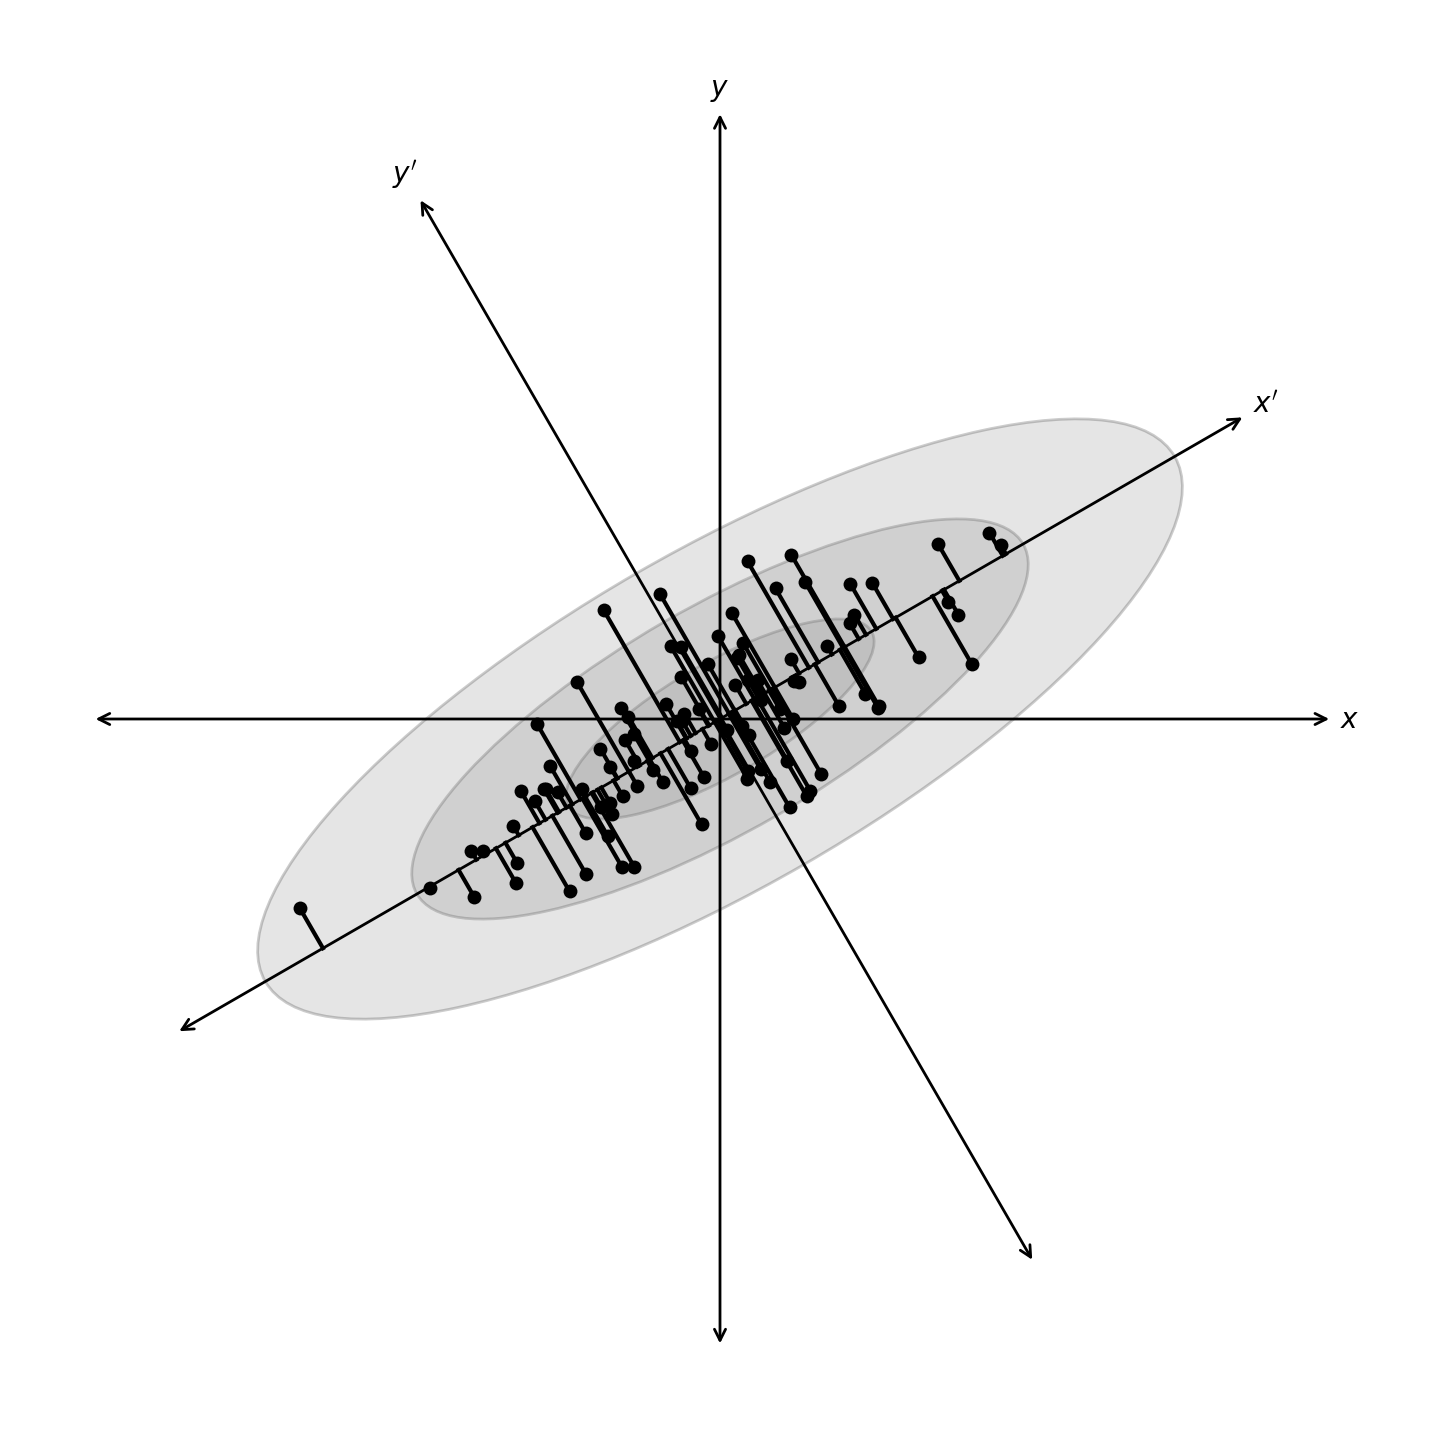

In [4]:
# Execute this cell
# Ivezic, Figure 7.2
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib.patches import Ellipse

#------------------------------------------------------------
# Set parameters and draw the random sample
np.random.seed(42)
r = 0.9

sigma1 = 0.25
sigma2 = 0.08
rotation = np.pi / 6
s = np.sin(rotation)
c = np.cos(rotation)

X = np.random.normal(0, [sigma1, sigma2], size=(100, 2)).T
R = np.array([[c, -s],[s, c]])
X = np.dot(R, X) #Same data, now rotated by R matrix.

#------------------------------------------------------------
# Plot the diagram
fig = plt.figure(figsize=(7, 7), facecolor='w')
ax = plt.axes((0, 0, 1, 1), xticks=[], yticks=[], frameon=False)

# draw axes
ax.annotate(r'$x$', (-r, 0), (r, 0),
            ha='center', va='center',
            arrowprops=dict(arrowstyle='<->', 
                            color='k', lw=1))
ax.annotate(r'$y$', (0, -r), (0, r),
            ha='center', va='center',
            arrowprops=dict(arrowstyle='<->', 
                            color='k', lw=1))

# draw rotated axes
ax.annotate(r'$x^\prime$', (-r * c, -r * s), (r * c, r * s),
            ha='center', va='center',
            arrowprops=dict(color='k', 
                            arrowstyle='<->', 
                            lw=1))
ax.annotate(r'$y^\prime$', (r * s, -r * c), (-r * s, r * c),
            ha='center', va='center',
            arrowprops=dict(color='k', 
                            arrowstyle='<->', 
                            lw=1))

# scatter points
ax.scatter(X[0], X[1], s=25, 
           lw=0, c='k', zorder=2)

# draw lines
vnorm = np.array([s, -c])
for v in (X.T):
    d = np.dot(v, vnorm)
    v1 = v - d * vnorm
    ax.plot([v[0], v1[0]], [v[1], v1[1]], '-k')

# draw ellipses
for sigma in (1, 2, 3):
    ax.add_patch(Ellipse(xy=(0, 0), width=2 * sigma * sigma1, height=2 * sigma * sigma2,
                         angle=rotation * 180. / np.pi,
                         ec='k', fc='gray', alpha=0.2, zorder=1))

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

plt.show()

Note that the points are correlated along a particular direction which doesn't align with the initial choice of axes. So, we should rotate our axes to align with this correlation. 

We'll choose the rotation to maximize the ability to discriminate between the data points:
*   the first axis, or **principal component**, is the direction of maximal variance
*   the second principal component is orthogonal to the first component and maximizes the residual variance
*   ...

**PCA is a dimensional reduction process because we can generally account for *nearly all* of the variance in the data set with fewer than the original $K$ dimensions.** See more below.

### Derivation of PCA

We start with a data set $\{x_i\}$ that consists of $N$ objects for which we measure $K$ features. The data is initially prepared by subtracting the mean for each feature in $\{x_i\}$ and writing $X$ as a $N\times K$ matrix.

The covariance of this matrix is the $K\times K$ matrix

$$C_X=\frac{1}{N-1}X^T X.$$

**There are off-diagonal terms if there are correlations between the measurements (e.g., maybe two of the features are temperature dependent and the measurements were taken at the same time).**


* If $R$ is a projection of the data that is aligned with the maximal variance, then we have $Y= X R$ with covariance 

$$ C_{Y} = R^T X^T X R = R^T C_X R.$$

* $r_1$ is the first principal component of $R$ (the first column) with the constraint $r_1^T r_1=1$. It can be derived using *Langrange multipliers* with the following cost function:

$$ \phi(r_1,\lambda_1) = r_1^TC_X r_1 - \lambda_1(r_1^Tr_1-1). $$

* If we take derivative of $\phi(r_1,\lambda)$ with respect to $r_1$ and set it to 0 (i.e., we extremize the cost function), then we have

$$ C_Xr_1 - \lambda_1 r_1 = 0. $$

* $\lambda_1$ (**the largest eigenvalue of the matrix**) is the root of the equation $\det(C_X -
\lambda_1 {\bf I})=0$ for which the eigenvalue is

$$ \lambda_1 =  r_1^T C_X r_1.$$

* The columns of the full matrix, $R$ are the **eigenvectors (known here as principal components)**.

* The diagonal values of $C_Y$ are the variance contained within each component.

We aren't going to go through the linear algebra more than that here, nor discuss the most efficient means of computation. See the end of 7.3.1 or go through [Karen Leighly's PCA lecture notes](http://seminar.ouml.org/lectures/principal-components-analysis/) if you want to walk through the math in more detail. **But PCA essentially boils down to eigen-analysis of data matrices, which I'm sure you have met previously in a math methods context.**

### Preparing data for PCA

1. Subtract the mean of each dimension/feature/column (to **"center"** the data)
2. Divide by the variance in each dimension/feature/column (to **"whiten"** the data)
3. (For spectra and images) normalize each sample/row to yield an integral of unity.

Below is a typical call to the PCA algorithm.  Note that this example is somewhat backwards.  We are starting with `X` and then we are making it higher dimensional--to create a mock high-$D$ data set.  Then we are applying PCA as a dimensionality reduction technique.

In [5]:
#Example call from 7.3.2
import numpy as np
from sklearn.decomposition import PCA

X = np.random.normal(size=(100,3)) # 100 points in 3D
R = np.random.random((3,10)) # projection matrix
X = np.dot(X,R) # X is now 10-dim, with 3 intrinsic dims

pca = PCA(n_components=4) # n_components can be optionally set
pca.fit(X) 

eigenvalues = pca.transform(X) # compute the subspace projection of X, 4 eigenvalues for each of the 100 samples
mean = pca.mean_ # length 10 mean of the data
eigenvectors = pca.components_ # 4x10 matrix of components, multiply each by respective eigenvalue to reconstruct

# Reconstruction of object1
# Xreconstruct[0] = mean + eigenvectors*eigenvalues[0]

print(eigenvalues.shape)
print(eigenvectors.shape)

(100, 4)
(4, 10)


To illustrate what is happening, here is a PCA reconstruction of handwritten "3s" from [Hastie et al.](https://web.stanford.edu/~hastie/ElemStatLearn/) :

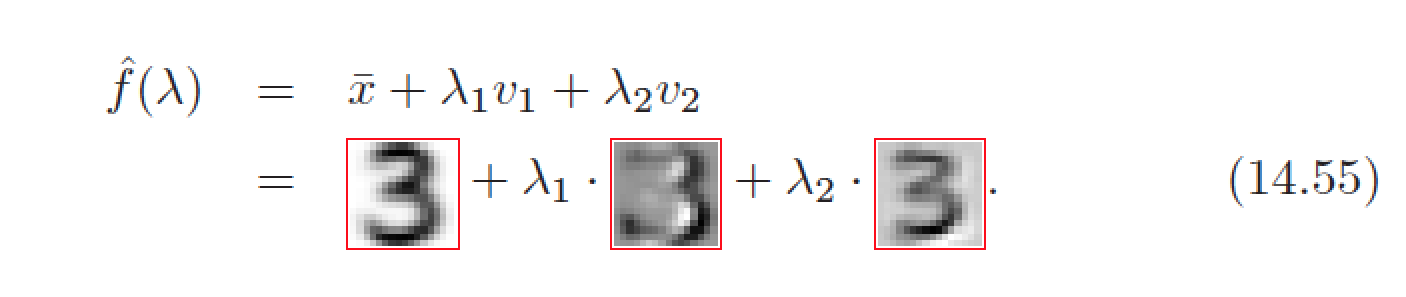

[Scikit-Learn's decomposition module](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) has a number of [PCA type implementations](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA).
Let's work through an example using spectra of galaxies taken during the Sloan Digital Sky Survey.  

In this sample there are 4000 spectra with flux measurements in 1000 bins.  15 example spectra are shown below and our example will use half of the spectra chosen at random.  

![Ivezic, Figure 7.1](http://www.astroml.org/_images/fig_spec_examples_1.png)

In [6]:
# Example from Andy Connolly
# See Ivezic, Figure 7.4

from sklearn.decomposition import PCA
#from sklearn.decomposition import RandomizedPCA

from astroML.datasets import sdss_corrected_spectra
from astroML.utils import pickle_results

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)
print('Number of spectra: ' + str(len(spectra)))
print('Number of wavelength bins: ' + str(len(wavelengths)))

#----------------------------------------------------------------------
# Compute PCA
np.random.seed(500)
nrows = 2000 # We'll just look at 2000 random spectra
n_components = 5 # Do the fit with 5 components, which is the mean plus 4
ind = np.random.randint(spectra.shape[0], size=nrows)

spec_mean = spectra[ind].mean(0) # Compute the mean spectrum, which is the first component
# spec_mean = spectra[:50].mean(0)

# use Randomized PCA for speed
# pca = RandomizedPCA(n_components - 1)
pca = PCA(n_components - 1, svd_solver='randomized')
pca.fit(spectra[ind])
pca_comp = np.vstack([spec_mean, pca.components_]) # Add the mean to the components
evals = pca.explained_variance_ratio_ 
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))

Number of spectra: 4000
Number of wavelength bins: 1000
Expained fractional variance of data encapsulated in the eigenvalues: [0.8893162  0.06058303 0.02481429 0.01012147]


**Now let's plot the components (eigenvectors).** The left hand panels are just the *first 5 spectra for comparison* with the *first 5 PCA components*, which are shown on the right.  They are ordered by the size of their eigenvalues.

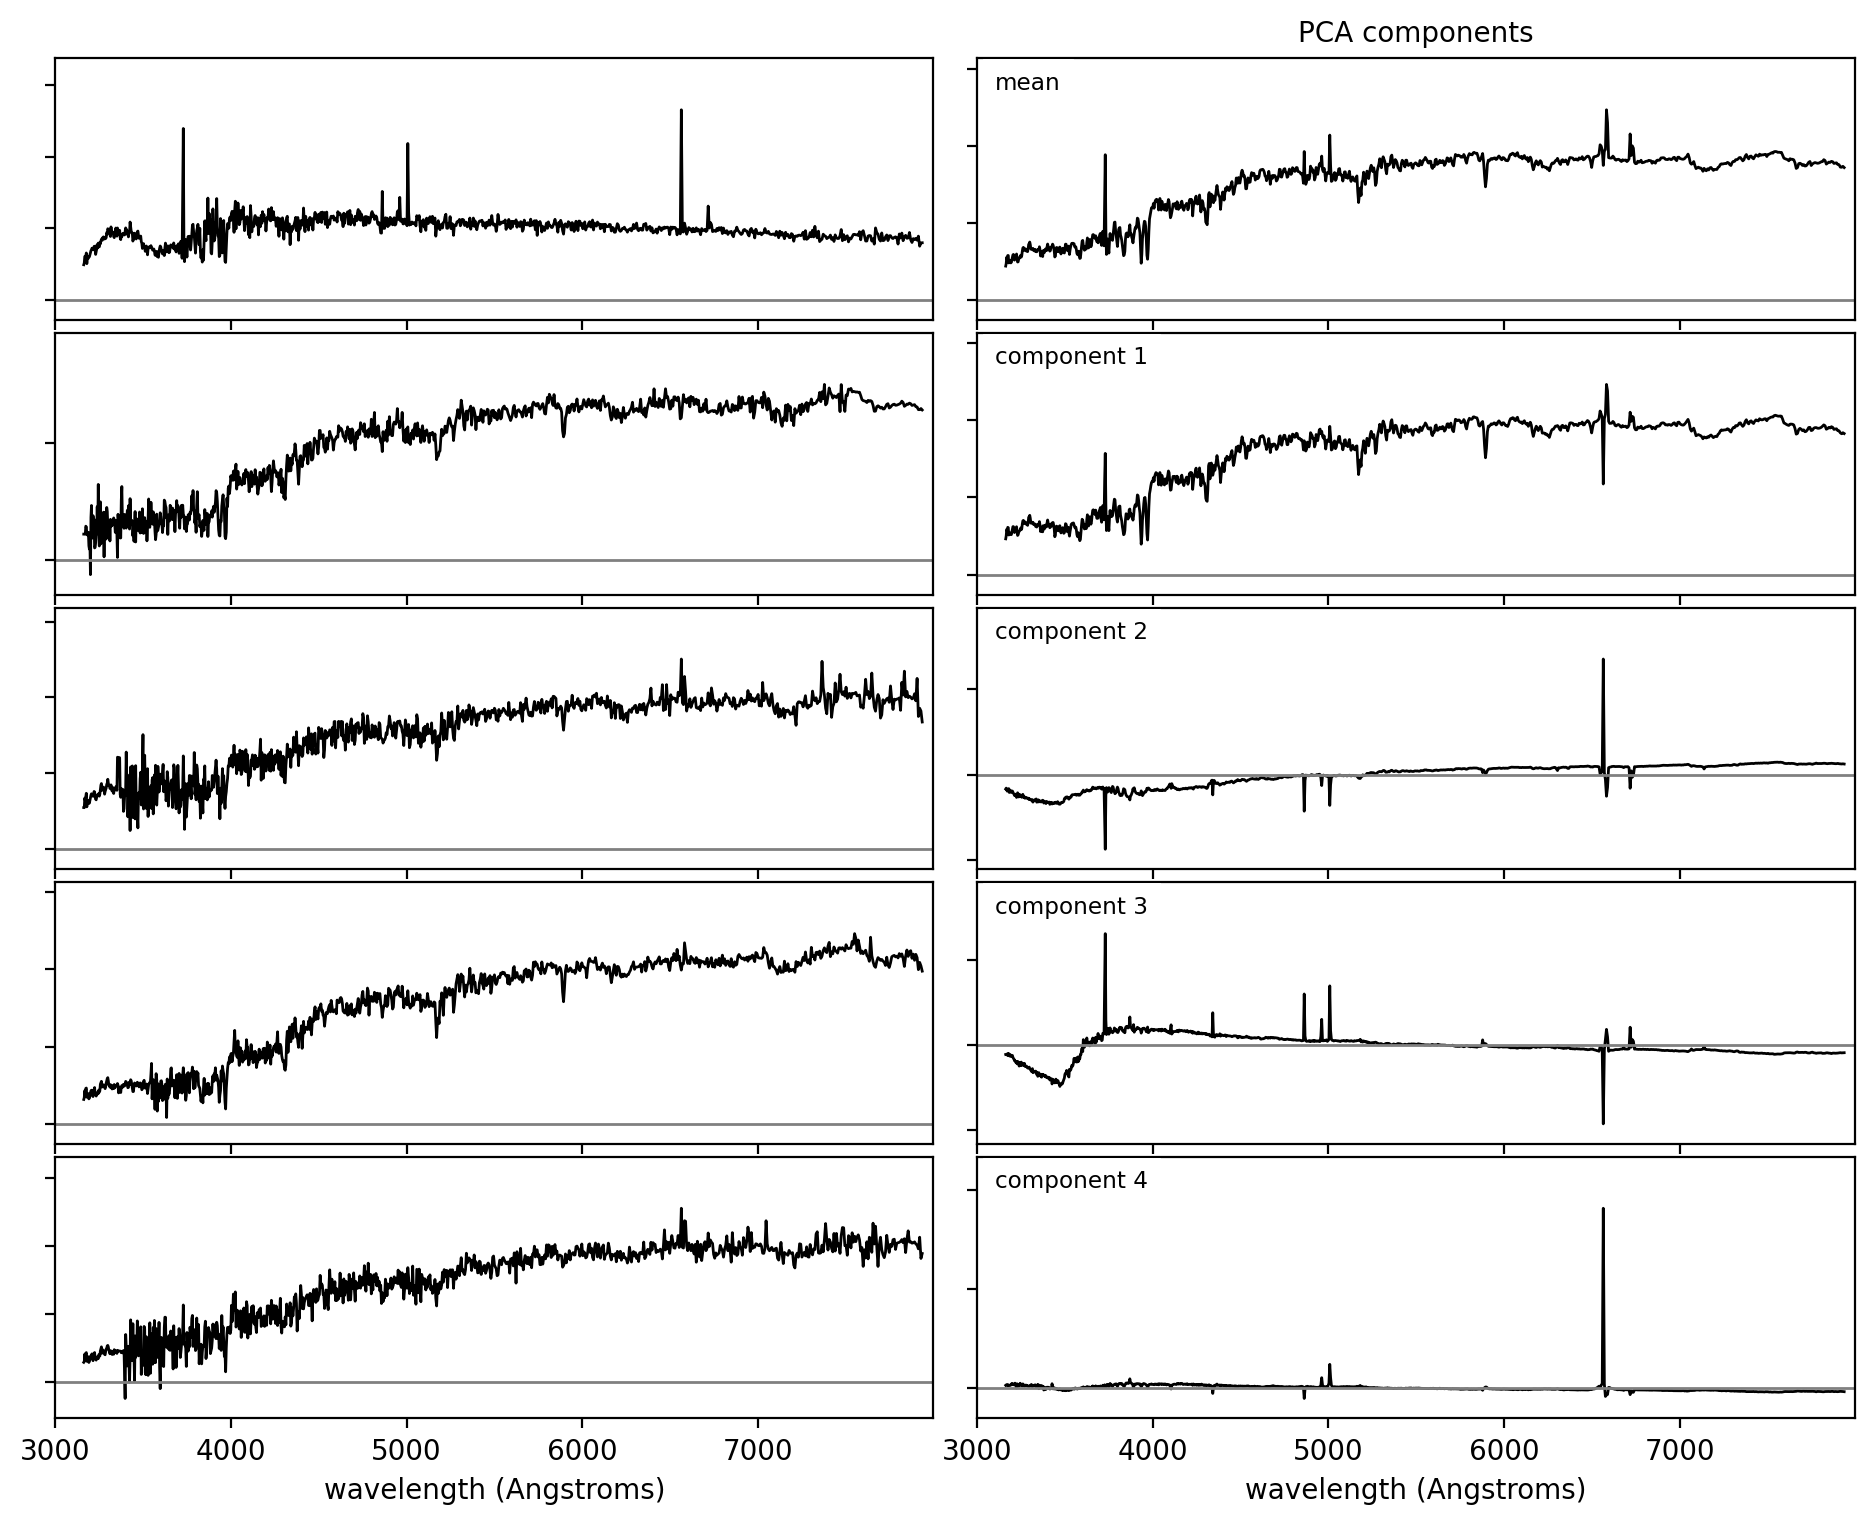

In [7]:
# Make plots
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = 'PCA components'

for j in range(n_components):
    
    # plot the components
    ax = fig.add_subplot(n_components, 2, 2*j+2)
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    
    if j < n_components - 1:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel('wavelength (Angstroms)')
    ax.plot(wavelengths, pca_comp[j], '-k', lw=1)

    # plot zero line
    xlim = [3000, 7999]
    ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax.set_xlim(xlim)

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)

    # plot the first j spectra
    ax2 = fig.add_subplot(n_components, 2, 2*j+1)
    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    ax2.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax2.set_xlabel('wavelength (Angstroms)')
    ax2.plot(wavelengths, spectra[j], '-k', lw=1)
    
    # plot zero line
    ax2.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax2.set_xlim(xlim)

    if j == 0:
        ax.set_title(titles, fontsize='medium')
    if j == 0:
        label = 'mean'
    else:
        label = 'component %i' % j

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax2.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)

    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='w', fc='w'),
            fontsize='small')

plt.show()

Now let's make **scree plots**.  These plots tell us how much of the variance is explained as a function of the each eigenvector.  Our plot won't look much like the textbook figure, so I've shown it below to explain where "scree" comes from.
![Ivezic, Figure 7.5](http://www.astroml.org/_images/fig_eigenvalues_1.png)

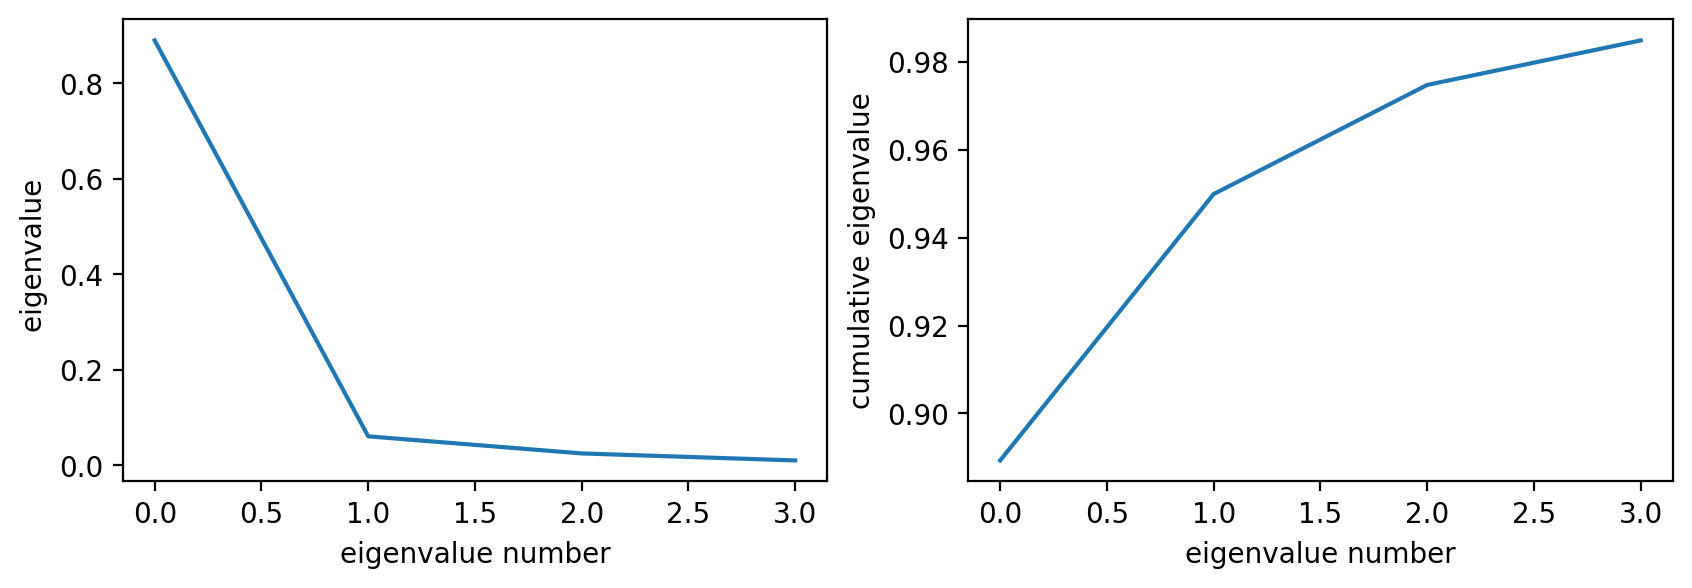

In [8]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(121)
ax.plot(np.arange(n_components-1), evals)
ax.set_xlabel("eigenvalue number")
ax.set_ylabel("eigenvalue ")

ax = fig.add_subplot(122)
ax.plot(np.arange(n_components-1), evals.cumsum())
ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative eigenvalue")

plt.show()

<font color='red'>How much of the variance is explained ([explained_variance_ratio_](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) by the first two components?  How about all of the components?</font>

In [9]:
print("The first component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[0]))
print("The second component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[1]))
print("All components explain {:.3f} of the variance in the data.".format(sum(pca.explained_variance_ratio_)))

The first component explains 0.889 of the variance in the data.
The second component explains 0.061 of the variance in the data.
All components explain 0.985 of the variance in the data.


***This is why PCA enables dimensionality reduction. We can use samples of measured data to train a data-driven basis that better explains it.***

<font color='red'>How many components would we need to explain 99.5% of the variance?</font>  

In [23]:
for num_feats in np.arange(1,20, dtype = int):
    pca = PCA(num_feats, svd_solver='randomized')
    pca.fit(spectra[ind])
    if (sum(pca.explained_variance_ratio_)>0.995):
        break
print("{:d} features are needed to explain 99.5% of the variance".format(num_feats))

8 features are needed to explain 99.5% of the variance


Note that we would need 1000 components to encode *all* of the variance. 

There is a MUCH easier way to do this.  Just give it a number of components between 0 and 1 and it will interpret that as a percentage of the variance.

In [24]:
pca995 = PCA(n_components=0.995)
pca995.fit(spectra[ind])
print("{:d} features are needed to explain 99.5% of the variance".format(pca995.n_components_))

8 features are needed to explain 99.5% of the variance


If you ever use sklearn's PCA, note that if you give it a dataset that is too big, it won't do the full PCA, but rather an approximated one using the `svd_solver="randomized"`, but you can force it to use something else.

### Interpreting the PCA

- The output eigenvectors are ordered by their associated eigenvalues 
- The eigenvalues reflect the variance within each eigenvector
- The sum of the eigenvalues is total variance of the system
- The projection of each spectrum onto the first few eigenspectra is a compression of the data 

Once we have the eigenvectors, we can reconstruct an observed spectrum, ${x}(k)$, in the eigenvector basis, ${e}_i(k)$, as 

$$ \begin{equation}
  {x}_i(k) = {\mu}(k) + \sum_j^R \theta_{ij} {e}_j(k).
\end{equation}
$$

where $\theta_{ij}$ denote the feature amplitudes in the compressed basis. The above equation would give a full (perfect) reconstruction of the data since it uses all of the eigenvectors. But if we truncate (i.e., $r<R$), then we will have reduced the dimensionality while still reconstructing the data with relatively little loss of information.

For example, we started with $4000\times1000$ floating point numbers. If we can explain nearly all of the variance with $8$ eigenvectors, then we have reduced the problem to $4000\times8 + 8\times1000$ floating point numbers!

Execute the next cell to see how the reconstruction improves by adding more components.

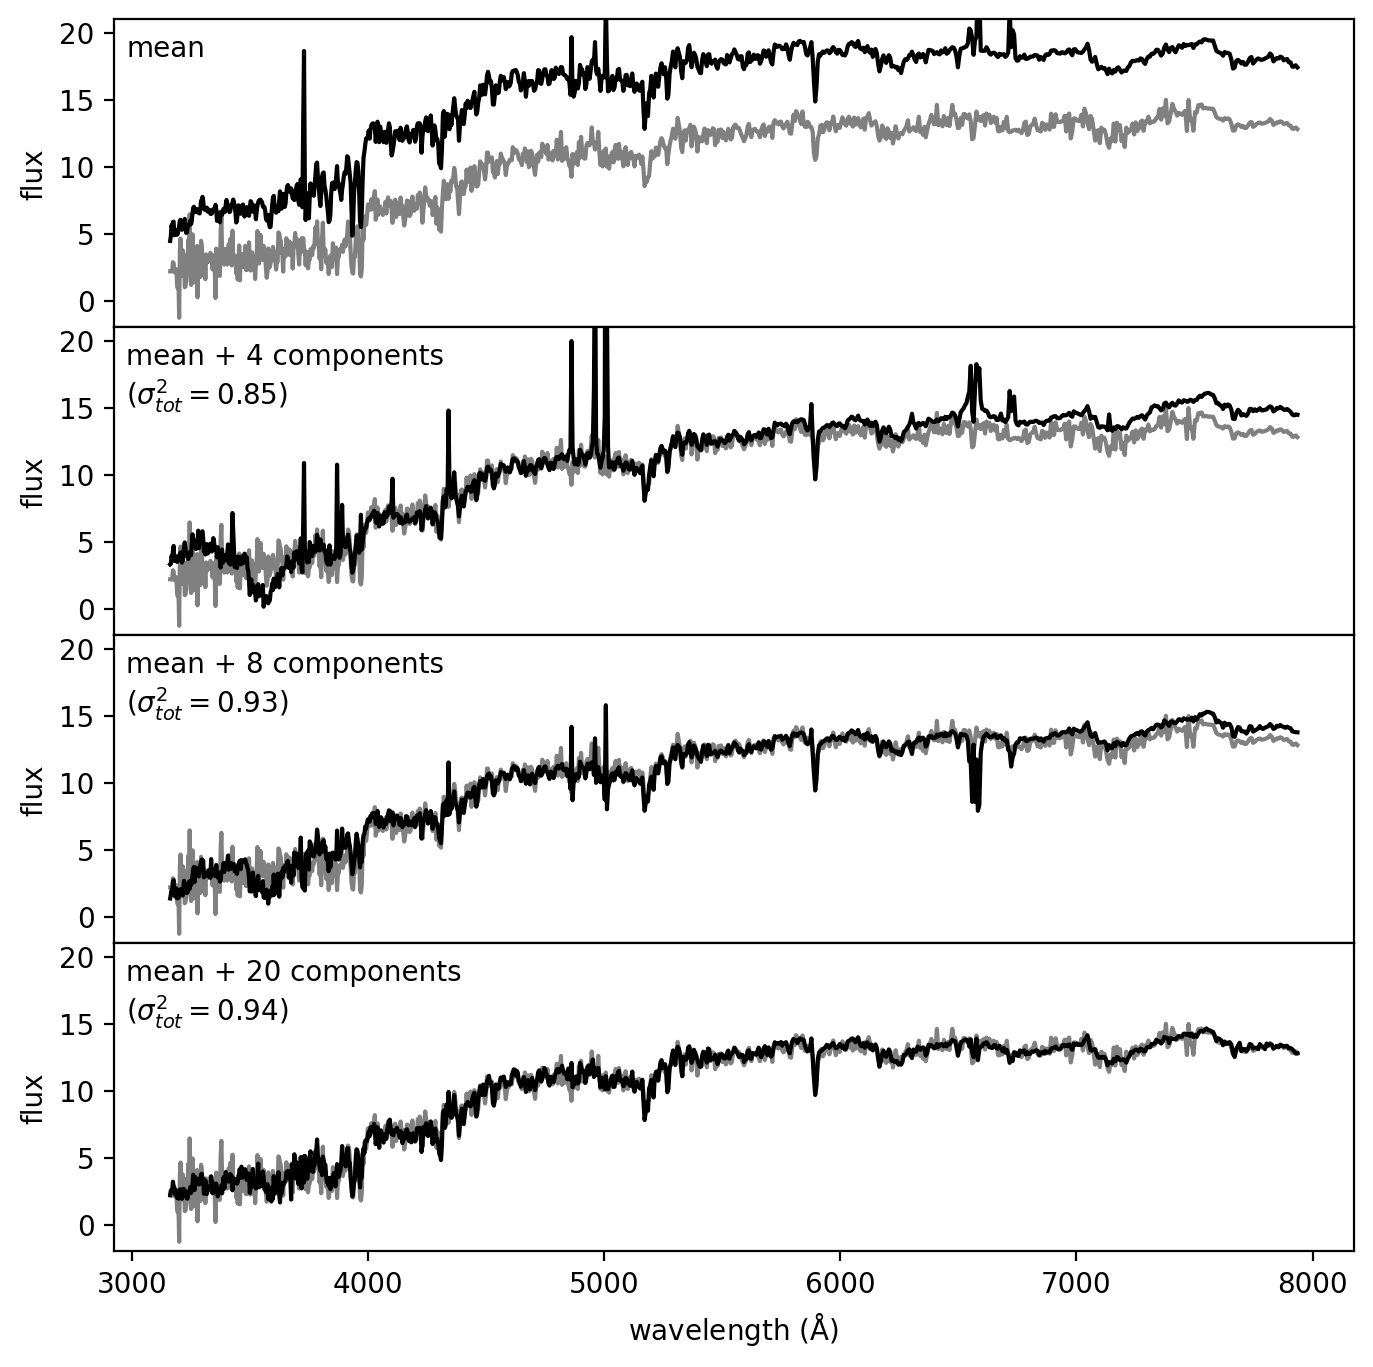

In [25]:
# Execute this cell
from sklearn.decomposition import PCA

from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#------------------------------------------------------------
# Compute PCA components

# Eigenvalues can be computed using PCA as in the commented code below:

#from sklearn.decomposition import PCA
#pca = PCA()
#pca.fit(spectra)
#evals = pca.explained_variance_ratio_
#evals_cs = evals.cumsum()

#  because the spectra have been reconstructed from masked values, this
#  is not exactly correct in this case: we'll use the values computed
#  in the file compute_sdss_pca.py
evals = data['evals'] ** 2
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]
evecs = data['evecs']
spec_mean = spectra.mean(0)

#------------------------------------------------------------
# Find the coefficients of a particular spectrum
spec = spectra[1]
coeff = np.dot(evecs, spec - spec_mean)

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0)

for i, n in enumerate([0, 4, 8, 20]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.01, 0.95, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

### Caveats

* **PCA is a linear process**, whereas the variations in the data may not be.  So it may not always be appropriate to use and/or may require a relatively large number of components to fully describe any non-linearity.
* Note also that **PCA can be very impractical for large data sets** which exceed the memory per core as the computational requirement goes as $\mathscr{O}(D^3$) and the memory requirement goes as $\mathscr{O}(2D^2)$.

### Missing Data
We have assumed so far that there is no missing data (e.g., bad pixels in the spectrum, etc.).  But often the data set is incomplete.  Since PCA encodes the flux correlation with wavelength (or whatever parameters are in your data set), we can actually use it to determine missing values.  

An example is shown below.
* Here, black are the observed spectra.
* Gray are the regions where we have no data.
* Blue is the PCA reconstruction, including the regions where there are no data. 

<>:67: SyntaxWarning: invalid escape sequence '\l'
<>:67: SyntaxWarning: invalid escape sequence '\l'
/var/folders/jr/6thm8wn52bv9_gbqq6c_j_ph0000gn/T/ipykernel_11600/116369427.py:67: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda\ (\AA)$')


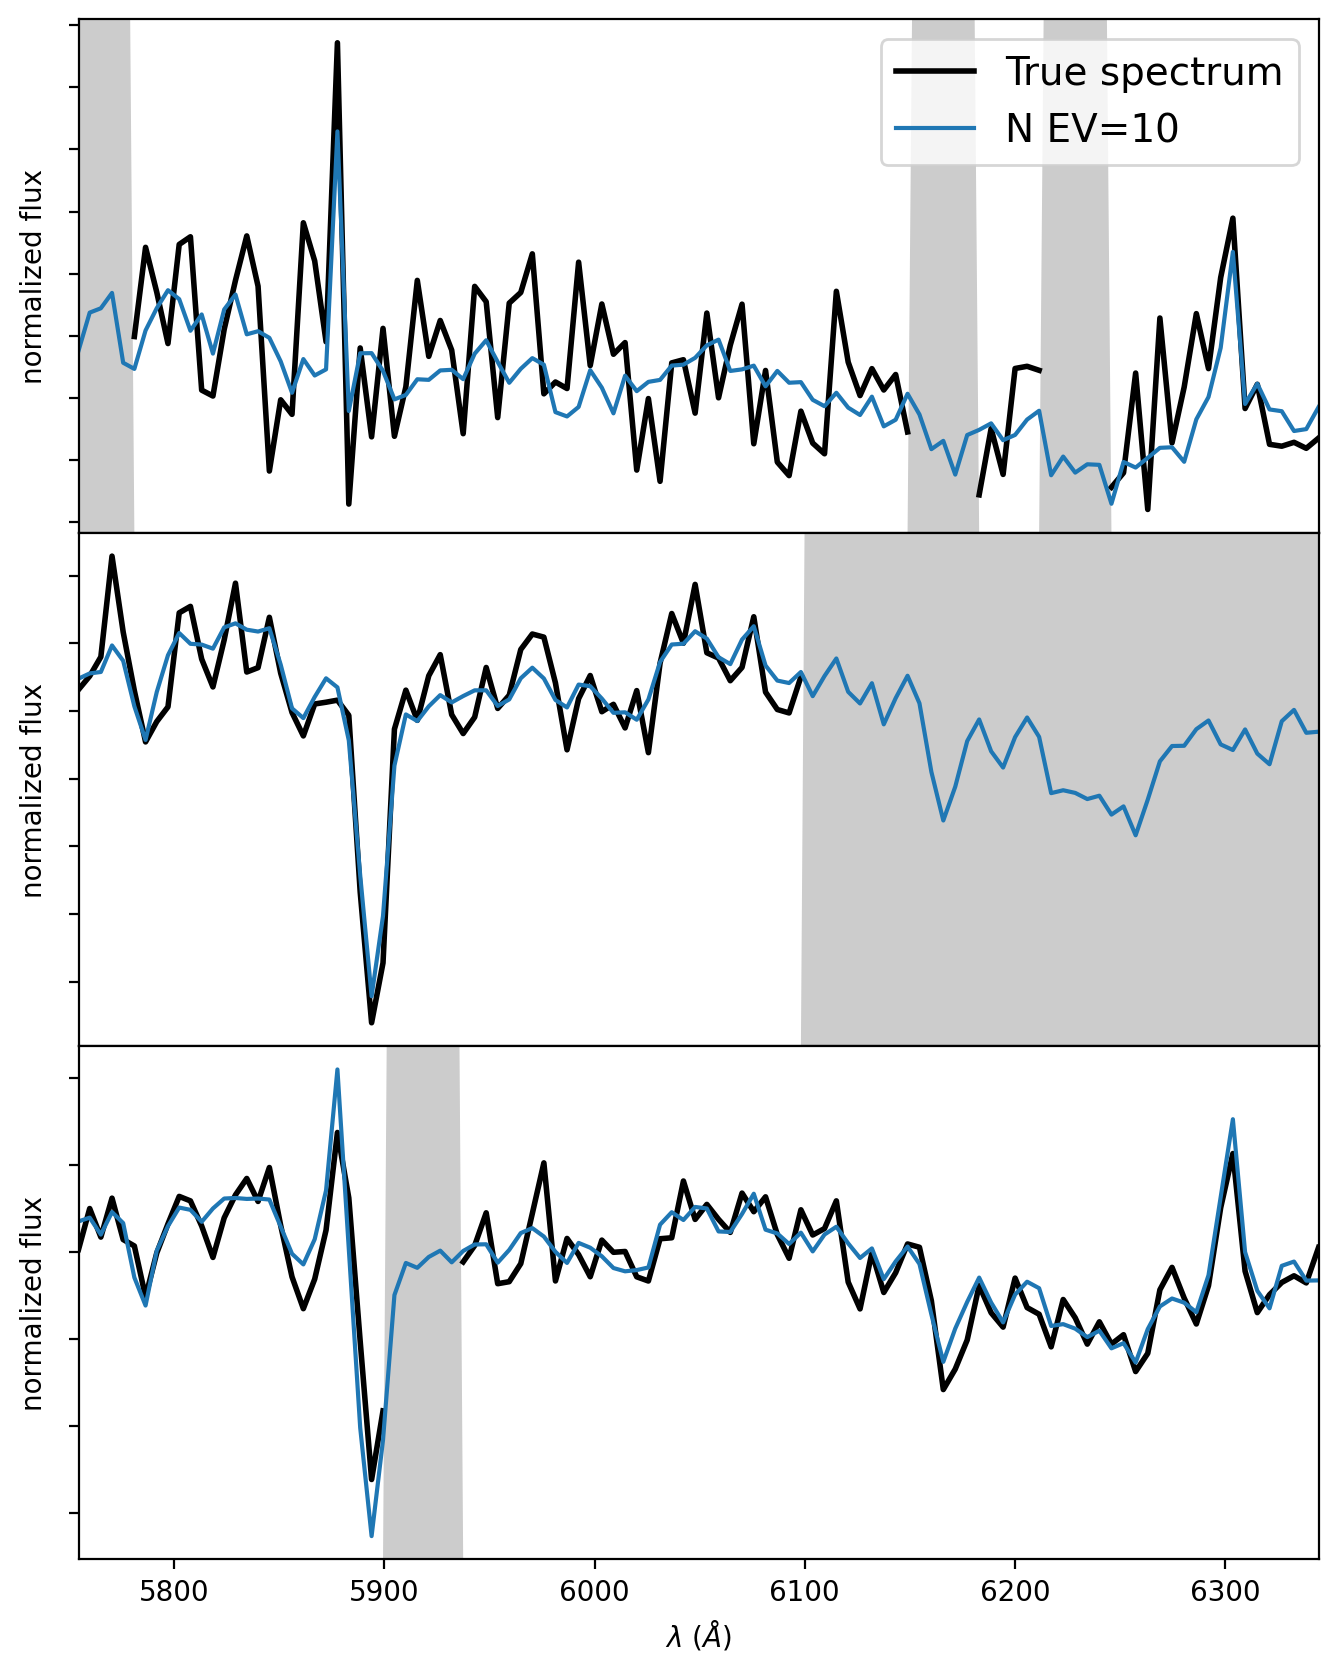

In [26]:
# Execute this cell
from matplotlib import ticker

from astroML.datasets import fetch_sdss_corrected_spectra
from astroML.datasets import sdss_corrected_spectra

#------------------------------------------------------------
# Get spectra and eigenvectors used to reconstruct them
data = fetch_sdss_corrected_spectra()
spec = sdss_corrected_spectra.reconstruct_spectra(data)
lam = sdss_corrected_spectra.compute_wavelengths(data)
evecs = data['evecs']
mu = data['mu']
norms = data['norms']
mask = data['mask']

#------------------------------------------------------------
# plot the results
i_plot = ((lam > 5750) & (lam < 6350))
lam = lam[i_plot]

specnums = [20, 8, 9]
subplots = [311, 312, 313]

fig = plt.figure(figsize=(8, 10))
fig.subplots_adjust(hspace=0)

for subplot, i in zip(subplots, specnums):
    ax = fig.add_subplot(subplot)

    # compute eigen-coefficients
    spec_i_centered = spec[i] / norms[i] - mu
    coeffs = np.dot(spec_i_centered, evecs.T)

    # blank out masked regions
    spec_i = spec[i]
    mask_i = mask[i]
    spec_i[mask_i] = np.nan

    # plot the raw masked spectrum
    ax.plot(lam, spec_i[i_plot], '-', color='k', lw=2,
            label='True spectrum')

    # plot two levels of reconstruction
    for nev in [10]:
        if nev == 0:
            label = 'mean'
        else:
            label = 'N EV=%i' % nev
        spec_i_recons = norms[i] * (mu + np.dot(coeffs[:nev], evecs[:nev]))
        ax.plot(lam, spec_i_recons[i_plot], label=label)

    # plot shaded background in masked region
    ylim = ax.get_ylim()
    mask_shade = ylim[0] + mask[i][i_plot].astype(float) * ylim[1]
    plt.fill(np.concatenate([lam[:1], lam, lam[-1:]]),
             np.concatenate([[ylim[0]], mask_shade, [ylim[0]]]),
             lw=0, fc='k', alpha=0.2)

    ax.set_xlim(lam[0], lam[-1])
    ax.set_ylim(ylim)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

    if subplot == 311:
        ax.legend(loc=1, prop=dict(size=14))

    ax.set_xlabel('$\lambda\ (\AA)$')
    ax.set_ylabel('normalized flux')

plt.show()

Awesome, right!?

How does this work? **PCA learns a data-driven basis that is a linear combination of features that best explain the observed data.** So it uses correlations across the features, which in this case are wavelengths. Those correlated features can be used to **interpolate across or reconstruct missing data**. 

The amplitudes of the reconstructed spectra in the compressed/PCA basis are given by

$$ \theta_i = \sum_j M^{-1}_{ij}F_j$$

where

$$ M_{ij} = \sum_k \mathbf{w}(k)\mathbf{e}_i(k)\mathbf{e}_j(k), \quad F_j = \sum_k \mathbf{w}(k)\mathbf{x}^\mathrm{obs}(k)\mathbf{e}_j(k)$$

and 
* $\sum_k$ sums over wavelengths or data features, 
* $\mathbf{x}^\mathrm{obs}(k)$ is the observed spectrum that is padded to include arbitrary entries for missing data, 
* $\mathbf{w}(k)$ are data weights that are $0$ for the missing data and $1/\sigma^2$ for the measured data, 
* $\mathbf{e}_i(k)$ are eigen-spectra.

With all of these in place, the PCA reconstruction of the missing data can be computed simply as $\sum_i \theta_i \mathbf{e}_i$.

The example that we have been using above is ***spectral PCA***.  Some examples from the literature include:
- [Francis et al. 1992](http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1992ApJ...398..476F&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf)
- [Connolly et al. 1995](http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1995AJ....110.1071C&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf)
- [Yip et al. 2004](http://iopscience.iop.org/article/10.1086/425626/meta;jsessionid=31BB5F11B85D2BF4180834DC71BA0B85.c3.iopscience.cld.iop.org)

One can also do PCA on features that aren't ordered (as they were for the spectra).  E.g., if you have $D$ different parameters measured for your objects.  A classic example in astronomy is
[Boroson & Green 1992](http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1992ApJS...80..109B&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf), and other more recent examples use it to learn about [pulsar pulse-shape variations](https://arxiv.org/abs/1707.08581), and to learn a data-driven basis of [binary black-hole demoragphic distributions for GW population inference](https://arxiv.org/abs/1806.08365).

## Non-negative Matrix Factorization (NMF) <a class="anchor" id="three"></a>

One of the biggest drawbacks of PCA is that the eigenvectors are defined relative to the mean data vector, resulting in principal components that can be positive or negative. But for many physical systems we know a-priori that the data can be represented as a linear sum of positive components, e.g., spectra, or the pdfs of physical properties of events. 

**[Non-negative Matrix Factorization (NMF)](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization)** treats the data as a linear sum of positive-definite components. 

NMF assumes that any data matrix with all positive elements can be factored into two matrices, $W$ and $Y$, with

$$ X = W Y, $$

where both $W$ and $Y$ are non-negative. 

So, $WY$ is an approximation of $X$. Minimizing the reconstruction error $|| (X - W Y)^2 ||$, 
nonnegative bases can be derived through an iterative process.

Note, however, that the iterative process does not guarantee nonlocal minima (like $K$-means and EM), but using 
random initialization and cross-validation can be used to find the global minimum.

An example from the literature is [Allen et al. 2008](http://arxiv.org/abs/0810.4231).

In Scikit-Learn the [NMF implementation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) looks like (...don't worry about warnings):

In [27]:
# Execute this cell
from sklearn.decomposition import NMF

X = np.random.random((100,10)) # 100 points in 10-D, all +ve
nmf = NMF(n_components=3)
nmf.fit(X)

W = nmf.transform(X) # project to 3 dimension
Y = nmf.components_ # 3x10 array of components
err = nmf.reconstruction_err_ # how well 3 components capture the data

#print(W)
#print(Y)
#print(err)

/Users/tejassewak/miniconda3/envs/astr3300/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


An example (and comparison to PCA) is given below.

In [28]:
# Execute the next 2 cells
# Example from Figure 7.4
# Author: Jake VanderPlas
# License: BSD
#from sklearn.decomposition import RandomizedPCA

from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

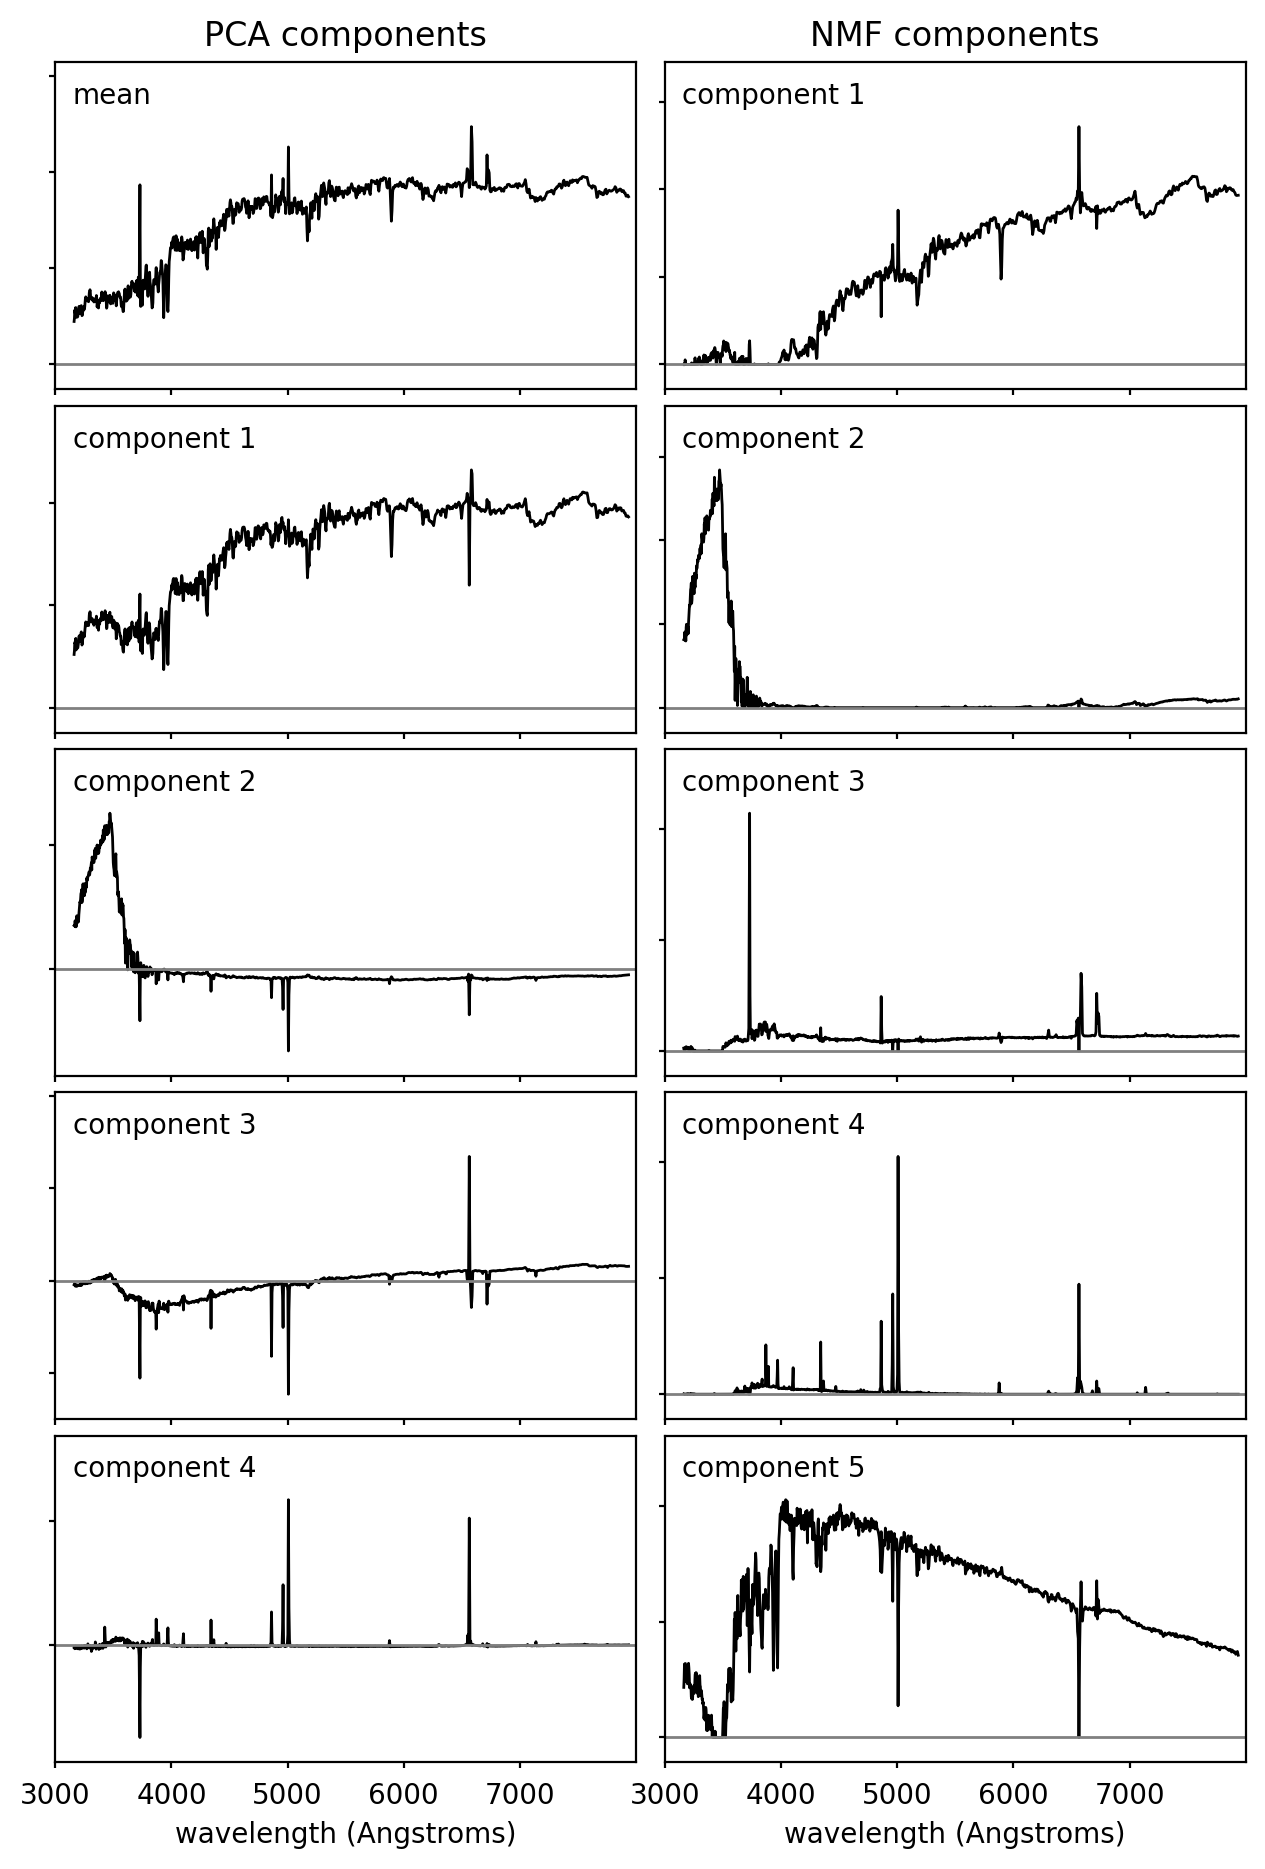

In [29]:
#----------------------------------------------------------------------
# Compute PCA, and NMF components
def compute_PCA_NMF(n_components=5):
    spec_mean = spectra.mean(0)

    # PCA: use randomized PCA for speed 
    #pca = RandomizedPCA(n_components - 1)
    pca = PCA(n_components - 1,svd_solver='randomized')
    pca.fit(spectra)
    pca_comp = np.vstack([spec_mean, pca.components_])

    # NMF requires all elements of the input to be greater than zero
    spectra[spectra < 0] = 0
    nmf = NMF(n_components)
    nmf.fit(spectra)
    nmf_comp = nmf.components_

    return pca_comp, nmf_comp

n_components = 5
decompositions = compute_PCA_NMF(n_components)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = ['PCA components', 'NMF components']

for i, comp in enumerate(decompositions):
    for j in range(n_components):
        ax = fig.add_subplot(n_components, 3, 3 * j + 1 + i)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.set_xlabel('wavelength (Angstroms)')

        ax.plot(wavelengths, comp[j], '-k', lw=1)

        # plot zero line
        xlim = [3000, 7999]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
        ax.set_xlim(xlim)

        if j == 0:
            ax.set_title(titles[i])

        if titles[i].startswith('PCA') or titles[i].startswith('ICA'):
            if j == 0:
                label = 'mean'
            else:
                label = 'component %i' % j
        else:
            label = 'component %i' % (j + 1)

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines(): 
            l.set_markersize(2) 

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])
        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)

plt.show()

See how all the NMF bases/components are positive? This is very useful!

## Independent Component Analysis (ICA) <a class="anchor" id="four"></a>

For data where the **components are statistically independent** (or nearly so) **[Independent Component Analysis (ICA)](https://en.wikipedia.org/wiki/Independent_component_analysis)** has become a popular method for separating mixed components.  

***The classical example is the so-called "cocktail party" problem.*** This is illustrated in the following figure from *Hastie, Tibshirani, & Friedman*. Think of the "source signals" as two voices at a party. You are trying to concentrate on just one voice.  What you hear is something like the "measured signals" pattern. You could run the data through PCA and that would do an excellent job of reconstructing the signal with reduced dimensionality, but it wouldn't actually isolate the different physical components (bottom-left panel). ICA on the other hand can (bottom-right panel).

![](./figures/hastie_ica.png)

You can find this image (as well as the entire textbook for free!) [here](https://web.stanford.edu/~hastie/ElemStatLearn//printings/ESLII_print12_toc.pdf).

[Hastie et al.](https://web.stanford.edu/~hastie/ElemStatLearn/): 
> *ICA applied to multivariate data looks for a sequence of orthogonal projections such that the projected data look as far from Gaussian as possible. With pre-whitened data, this amounts to looking for
components that are as independent as possible.*

In short you want to ***find components that are maximally non-Gaussian***, since the sum of two or more random variables will be more Gaussian than either of the components individually (remember the **Central Limit Theorem**). *Hastie et al.* illustrate this as follows:

![](figures/hastie_ica2.png)

ICA is a good choice for a complex system with relatively independent components. For example a galaxy is roughly a linear combination of cool stars and hot stars, and a quasar is just a galaxy with others component from an accretion disk and emission line regions. **Ideally we want "eigenvectors" that are aligned with those physical traits/regions as opposed to abstract mathematical constructs.**

The basic call to the [FastICA algoirthm](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html) in Scikit-Learn looks like:

In [ ]:
# Execute this cell
from sklearn.decomposition import FastICA

X = np.random.normal(size=(100,2)) # 100 objects in 2D
R = np.random.random((2,5)) # mixing matrix
X = np.dot(X,R) # Simulation of a 5D data space

ica = FastICA(n_components=2) # Now reproject to 2-D
ica.fit(X)

proj = ica.transform(X) # 100x2 projection of the data
comp = ica.components_ # 2x5 matrix of independent components
## sources = ica.sources_ # 100x2 matrix of sources

Execute the next 2 cells to produce a plot showing the ICA components of the SDSS spectra.

In [ ]:
from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#----------------------------------------------------------------------
# Compute ICA
np.random.seed(500)
nrows = 500
n_components = 5
ind = np.random.randint(spectra.shape[0], size=nrows)

spec_mean = spectra[ind].mean(0)

ica = FastICA(n_components - 1)
ica.fit(spectra[ind])
ica_comp = np.vstack([spec_mean,ica.components_]) # Add the mean to the components

In [ ]:
# Make plots
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = 'ICA components'

for j in range(n_components):
    
    # plot the components
    ax = fig.add_subplot(n_components, 2, 2*j+2)
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel(r'wavelength ${\rm (\AA)}$')
    ax.plot(wavelengths, ica_comp[j], '-k', lw=1)

    # plot zero line
    xlim = [3000, 7999]
    ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax.set_xlim(xlim)

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)

    # plot the first j spectra
    ax2 = fig.add_subplot(n_components, 2, 2*j+1)
    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    ax2.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax2.set_xlabel(r'wavelength ${\rm (\AA)}$')
    ax2.plot(wavelengths, spectra[j], '-k', lw=1)
    
    # plot zero line
    ax2.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax2.set_xlim(xlim)

    if j == 0:
        ax.set_title(titles, fontsize='medium')

    if j == 0:
        label = 'mean'
    else:
        label = 'component %i' % j

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax2.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)


    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='w', fc='w'),
            fontsize='small')

plt.show()

ICA actually looks like it is picking up distinct line regions as the components.

As with PCA and NMF, we can similarly do a reconstruction:

In [ ]:
# Execute this cell
#------------------------------------------------------------
# Find the coefficients of a particular spectrum
spec = spectra[1]
evecs = data['evecs']
coeff = np.dot(evecs, spec - spec_mean)

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0)

for i, n in enumerate([0, 2, 4, 8]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        #text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        #text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
        
    ax.text(0.01, 0.95, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

Ivezic, Figure 7.7 compares the components found by the PCA, ICA, and NMF algorithms.  Their differences and similarities are quite interesting.

![Ivezic, Figure 7.4](http://www.astroml.org/_images/fig_spec_decompositions_1.png)

If you think that I was pulling your leg about the cocktail problem, try it yourself!
<font color='red'>Load the code instead of running it and see what effect changing some things (like number of components) has.</font>

In [ ]:
%load ./scripts/plot_ica_blind_source_separation.py

***Let's revisit the digits sample and see what PCA, NMF, and ICA do for it.***

In [ ]:
## Execute this cell to load the digits sample

from sklearn.datasets import load_digits

digits = load_digits()
grid_data = np.reshape(digits.data[0], (8,8)) #reshape to 8x8
plt.imshow(grid_data, interpolation = "nearest", cmap = "bone_r")
print(grid_data)
X = digits.data
y = digits.target

<font color='red'>Do the PCA transform, projecting to 2 dimensions and plot the results.</font>

In [ ]:
# PCA
from sklearn.decomposition import ___
pca = PCA(n_components = ___)
pca.___(___)
X_reduced = pca.transform(___)

plt.scatter(X_reduced[:,___], X_reduced[:,___], 
            c=y, cmap="nipy_spectral", edgecolor="None")
plt.colorbar()

<font color='red'>Similarly for NMF and ICA.</font>

In [ ]:
# NMF
from sklearn.decomposition import ___
nmf = NMF(___)
nmf.___(___)
X_reduced = nmf.___(___)

plt.scatter(___, ___, 
            c=y, cmap="nipy_spectral", edgecolor="None")
plt.colorbar()

In [ ]:
# ICA
from sklearn.decomposition import ___
ica = FastICA(___)
ica.___(___)
X_reduced = ica.___(___)

plt.scatter(___, ___, 
            c=y, cmap="nipy_spectral", edgecolor="None")
plt.colorbar()

Take a second to think about what ICA is doing.  What if you had digits from digital clocks instead of handwritten?

We could think about doing dimensional reduction of the digits data set in another way.  There are 64 pixels in each of our images. Presumably all of them aren't equally useful. Let's figure out exactly which pixels are the most relevant to determining the written number. We'll use Scikit-Learn's [`RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).  We won't get to regression until next week, but you don't need to understand the algorithm to do this, just look at the inputs and outputs. Which pixels are the most important? *As a bonus see if you can plot one of the digit images with the most important few pixels highlighted.*

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RFreg = RandomForestRegressor() # Complete or leave blank as you see fit
RFreg.fit(X,y) # Do Fitting
importances = RFreg.feature_importances_# Determine pixel "importances"
pixelorder = np.argsort(importances)[::-1] # Rank importances (highest to lowest)
print(pixelorder) 

plt.figure()
plt.imshow(np.reshape(importances,(8,8)),
           interpolation="nearest")
plt.show()